# Extended (Cobey) Model Generator
### Reese Richardson
##### 4-09-2020

This Jupyter notebooks handles everything related to generating trajectories, from deciding what parameters to use to writing necessary bash scripts for Quest, to combining trajectories post-run.

In [1]:
import numpy as np
import pandas as pd
import itertools
import os

In [2]:
def gen_samples(sample_params_csv_base = './sampled_parameters', samples=20, pop=12830632):
    
    #Function generates csv and DataFrame of sampled_parameters,
    #specified below. Samples specifies number of samples used.
    #Population specified by 'pop'.
    
    df =  pd.DataFrame()
    df['sample_index'] = range(samples) #Be sure that your index contains the substring 'index!'
    df['speciesS'] = pop
    df['initialAs'] = 10 #np.random.uniform(1, 5, samples)

    df['incubation_pd'] = np.random.uniform(4.2, 6.63, samples)
    df['time_to_symptoms'] = np.random.uniform(1, 5, samples)
    df['time_to_hospitalization'] = np.random.uniform(2, 10, samples)
    df['time_to_critical'] = np.random.uniform(4, 9, samples)
    df['time_to_death'] = np.random.uniform(3, 11, samples)
    df['recovery_rate_asymp'] = np.random.uniform(6, 16, samples)
    df['recovery_rate_mild'] = np.random.uniform(19.4, 21.3, samples)
    df['recovery_rate_hosp'] = np.random.uniform(19.5, 21.1, samples)
    df['recovery_rate_crit'] = np.random.uniform(25.3, 31.6, samples)
    df['fraction_symptomatic'] = np.random.uniform(0.5, 0.8, samples)
    df['fraction_severe'] = np.random.uniform(0.2, 0.5, samples)
    df['fraction_critical'] = np.random.uniform(0.2, 0.5, samples)
    #df['fraction_critical'] = np.random.uniform(0.15, 0.35, samples)
    #df['fraction_critical'] = np.random.uniform(0.15, 0.45, samples)
    #df['cfr'] = np.random.uniform(0.008, 0.022, samples)
    #df['cfr'] = np.random.uniform(0.0009, 0.0017, samples)
    #df['cfr'] = np.random.uniform(0.00445, 0.01185, samples)
    df['cfr'] = np.random.uniform(0.002675, 0.007775, samples)
    df['fraction_dead'] = df.apply(lambda x: x['cfr'] / x['fraction_severe'], axis=1)
    df['fraction_hospitalized'] = df.apply(lambda x: 1 - x['fraction_critical'] - x['fraction_dead'], axis=1)
    df['reduced_inf_of_det_cases'] = np.random.uniform(0.5, 0.9, samples)
    df['d_Sym'] = np.random.uniform(0.2, 0.3, samples)
    df['d_Sys'] = np.random.uniform(0.7, 0.9, samples)
    df['d_As'] = np.random.uniform(0, 0, samples)
    #df['Ki'] = np.random.uniform(2.e-7, 2.5e-7, samples)

    df['social_multiplier_1'] = np.random.uniform(0.9, 1, samples)
    df['social_multiplier_2'] = np.random.uniform(0.6, 0.9, samples)
    df['social_multiplier_3'] = np.random.uniform( 0.005 , 0.3, samples) #0.2, 0.6

    df['socialDistance_time1'] = 32 # 24  ## (+8 for NMH)
    df['socialDistance_time2'] = 37 # 29  ## (+8 for NMH)
    df['socialDistance_time3'] = 41 # 33  ## (+8 for NMH)

    df.to_csv(sample_params_csv_base + '.csv', index=False) #Writing to csv...
    
    return df

In [3]:
def gen_scenarios(scenarios_csv_base='./scenarios', nscenarios=5, log=False):
    
    #Function generates csv and DataFrame of scenarios, varying
    #the parameters specified below in either a linear space
    #with nscenarios instances or a logspace with nscenarios
    #instances. This function only determines K_i right now,
    #where the lowest K_i and highest K_i are specified below.
    
    #Specify min and max of K_i to iterate over.
    K_i_low = 3.5e-8
    K_i_high = 5.3e-8
    
    df = pd.DataFrame()
    df['scenario_index'] = range(nscenarios) #Be sure that your index contains the substring 'index!'
    
    if log: #Log Space (Probably only use if K_i_low << K_i_high)
        df['Ki'] = np.logspace(start=np.log10(K_i_low), stop=np.log10(K_i_high), num=nscenarios)
    else: #Linear Space (Default)
        df['Ki'] = np.linspace(start=K_i_low, stop=K_i_high, num=nscenarios)
        
    df.to_csv(scenarios_csv_base + '.csv', index=False) #Writing to csv...
    
    return df

In [4]:
def gen_combos(csv_base_list=['./sampled_parameters', './scenarios'], output_base='./master_input'):
    
    #Function takes list of csv bases, generates a master
    #csv file with all combinations of parameters contained therein.
    #Ensure that all parameters have unique names in input files
    #and that multiple input files are supplied.
    
    dfs_list = ['']*(len(csv_base_list)) #Initialize list to store DataFrames
    
    #Importing data...
    base_index = 0
    for base in csv_base_list:
        fullname = './' + base + '.csv'
        csv_df = pd.read_csv(fullname, header=0).dropna(axis='columns') #Import csv
        dfs_list[base_index] = csv_df.copy()
        base_index += 1
        
    #Restructuring data in lists with all possible combinations...    
    cool_list = np.array(list(itertools.product(dfs_list[0].to_numpy(),dfs_list[1].to_numpy())))
    cool_list = np.array(list(np.concatenate(x) for x in cool_list))
    for i in range(2,len(dfs_list)):
        cool_list = np.array(list(itertools.product(cool_list,dfs_list[i].to_numpy())))
        cool_list = np.array(list(np.concatenate(x) for x in cool_list))
    
    #Creating a list of columns for use in the final DataFrame...
    master_columns = []
    for df in dfs_list:
        master_columns.extend(np.array(df.columns))
    
    #Isolating index columns...
    index_columns = []
    for col in master_columns:
        if 'index' in col:
            index_columns.append(col)
    
    #Writing all data to master DataFrame...
    master_df = pd.DataFrame(data=cool_list, columns=master_columns)
    
    #Restructuring master DataFrame to bring index columns to front...
    master_df = master_df[[c for c in master_df if c in index_columns]+[c for c in master_df if c not in index_columns]]
    
    #Writing master dataframe to output csv.
    master_df.to_csv(output_base+'.csv')
    
    return master_df

In [5]:
def make_folders(emodl_and_cfg_folder='emodls', trajectories_folder='trajectories'):
    
    #This function makes the emodls and cfg directory,
    #as well as the trajectories_folder.
    #No other functions call this function, so if
    #you decide to manually make your emodl files,
    #you do not need to call this funciton.
    
    if not (os.path.isdir(emodl_and_cfg_folder)):
        os.mkdir(emodl_and_cfg_folder)
    if not (os.path.isdir(trajectories_folder)):
        os.mkdir(trajectories_folder)

In [6]:
def gen_emodls(emodl_base='./emodl_', cfg_base='./cfg_', master_input_base='./master_input_4grps', template_emodl_base='./extendedmodel_cobey_age_4grp', \
               duration=365, nruns=3, monitoring_samples=365, prefix='trajectories_', \
               template_cfg_base='./extendedmodel_cobey_age_4grp'):
    
    #Function takes master csv file (output of gen_combos from
    #combine_to_master_input_csv.py) and creates an emodl file
    #and corresponding cfg file for each line for each line.
    #Everything that goes in the emodl is contained within the
    #master csv file, whereas everything that goes in the cfg
    #file is determined at call (duration, nruns, nsamples,
    #etc...). Prefix emodl_base will also be used as the prefix
    #for the output cfg files.
    
    #Read in master input csv to DataFrame...
    master_df = pd.read_csv(master_input_base + '.csv', index_col=0)
    columns = list(master_df.columns)         
    
    #Read in template emodl and cfg as strings...
    template_emodl = open(template_emodl_base + '.emodl', 'r') 
    template_e_txt = template_emodl.read() #Read in template emodl as string
    template_emodl.close()
    
    template_cfg = open(template_cfg_base + '.cfg', 'r') 
    template_c_txt = template_cfg.read() #Read in template emodl as string
    template_cfg.close()
    
    
    #Create an emodl file and cfg file with specified base for each row...
    for index, row in master_df.iterrows():
        template_e = template_e_txt #Writing to output emodl
        for col in columns:
            if ('@' + col + '@') in template_e:
                template_e = template_e.replace('@' + col + '@', str(row[col]))
        output_emodl = open(emodl_base + str(index) + '.emodl', 'w')
        output_emodl.write(template_e)
        output_emodl.close()
        
        template_c = template_c_txt #Writing to output cfg
        template_c = template_c.replace('@duration@', str(duration))
        template_c = template_c.replace('@nruns@', str(nruns))
        template_c = template_c.replace('@monitoring_samples@', str(duration))
        template_c = template_c.replace('@prefix@', prefix + str(index))
        output_cfg = open(cfg_base + str(index) + '.cfg', 'w')
        output_cfg.write(template_c)
        output_cfg.close()

In [38]:
def gen_batch(compartments_path='..\CMS\compartments.exe', emodl_base='.\emodl_', cfg_base='.\cfg_', \
              nsims=100, bat_file_base='run_simulations'):
    
    #Function generates batch file which can be run from
    #Windows Explorer (click 'Run as Administrator').
    #NOTE that the .bat file uses windows file structure, so
    #make sure your emodl_base and cfg_base contain '\'s, not
    #'/'s!
    #You can also specify the path to the CMS binary via
    #compartments_path.
    
    file = open(bat_file_base + '.bat', 'w')
    file.write("ECHO start" + "\n" + "FOR /L %%i IN (0,1,{}) DO ( {} -c {} -m {})".format(
        str(nsims-1),
        compartments_path,
        cfg_base+'%%i'+'.cfg',
        emodl_base+'%%i'+'.emodl') + "\n ECHO end")
    
    file.close()

In [8]:
def gen_quest(emodl_base='./emodl_', cfg_base='./cfg_', nsims=100, quest_file_base='run_simulations'):
    
    #Function generates batch file which can be run on
    #Quest (sbatch run_simulations.sh)! To change any
    #of the parameters in the header, simply modify
    #'header' below.
    
    file = open(quest_file_base + '.sh', 'w')
    header = """#!/bin/bash
#SBATCH -A p30781                               # Allocation
#SBATCH -p normal                               # Queue
#SBATCH -t 04:00:00                             # Walltime/duration of the job
#SBATCH -N 1                                    # Number of Nodes
#SBATCH --mem=18G                               # Memory per node in GB needed for a job. Also see --mem-per-cpu
#SBATCH --ntasks-per-node=1                     # Number of Cores (Processors)
#SBATCH --mail-user=rakr@u.northwestern.edu     # Designate email address for job communications
#SBATCH --mail-type=END                         # Events options are job BEGIN, END, NONE, FAIL, REQUEUE
#SBATCH --output=./output.txt                   # Path for output must already exist
#SBATCH --error=./error.txt                     # Path for errors must already exist
#SBATCH --job-name="CMS_simulation"             # Name of job\n\n\n"""
    file.write(header)
    
    file.write('module load singularity\n\n\n')
    
    #The loop below is written such that each
    #simulation requires a line in the submission text.
    #This is a bad way to code it, but not inherently
    #harmful. Will update once I am on Quest (4-9-20).
    
    for i in range(nsims):
        file.write('singularity exec ../singwine-v1.img wine ../CMS/compartments.exe -c ' \
                   + cfg_base + str(i) + '.cfg ' + '-m ' + emodl_base + str(i) + '.emodl\n')
    file.close()

### Testing...

Note that in the future, the above functions could be modified such that each does not read in .csvs, does not output a .csv, and can instead read in the DataFrame output of the previous function. However, this does not do much to impact runtime (additionally, .csvs are useful to keep for replicability/documentation purposes).

In [52]:
#Testing gen_samples...
samples_df = gen_samples(sample_params_csv_base = './sampled_parameters', samples=20, pop=12830632)

#Testing gen_scenarios...
scenarios_df = gen_scenarios(scenarios_csv_base='./scenarios', nscenarios=5, log=False)

#Testing gen_combos...
combos_df = gen_combos(csv_base_list=['./sampled_parameters', './scenarios'], output_base='./master_input')

#Testing make_folders...
make_folders(emodl_and_cfg_folder='emodls_cfgs', trajectories_folder='trajectories')

#Testing gen_emodls...
gen_emodls(emodl_base='./emodls_cfgs/emodl_', cfg_base = './emodls_cfgs/cfg_', master_input_base='./master_input', template_emodl_base='./template', \
               duration=365, nruns=3, monitoring_samples=365, prefix='./trajectories/trajectories_', \
               template_cfg_base='./template')

#Testing gen_batch...
gen_batch(emodl_base='.\emodls_cfgs\emodl_', cfg_base='.\emodls_cfgs\cfg_', nsims=len(combos_df), bat_file_base='run_simulations')

#Testing gen_quest...
gen_quest(emodl_base='./emodls_cfgs/emodl_', cfg_base='./emodls_cfgs/cfg_', nsims=len(combos_df), quest_file_base='run_simulations')

# Read this!

### After the above block has completed...
...run your .bat file on Windows or submit your .sh file to Quest!

This leaves you with a populated trajectories folder.

In [53]:
def reprocess(input_fname='trajectories.csv', output_fname=None):
    
    #Function combines the trajectories of each run
    #in a single simulation into a DataFrame. 
    #"Run Number" is stored as run_index.
    #Called by combine_trajectories.
    
    row_df = pd.read_csv(input_fname, skiprows=1)
    df = row_df.set_index('sampletimes').transpose()
    run_time = len([x for x in df.columns.values if '{0}' in x])
    num_runs = int((len(row_df)) / run_time)

    df = df.reset_index(drop=False)
    df = df.rename(columns={'index': 'time'})
    df['time'] = df['time'].astype(float)

    adf = pd.DataFrame()
    for run_num in range(num_runs):
        channels = [x for x in df.columns.values if '{%d}' % run_num in x]
        sdf = df[['time'] + channels]
        sdf = sdf.rename(columns={
            x: x.split('{')[0] for x in channels
        })
        sdf['run_index'] = run_num
        adf = pd.concat([adf, sdf])

    adf = adf.reset_index()
    del adf['index']
    if output_fname:
        adf.to_csv(os.path.join(temp_exp_dir,output_fname), index=False)
    return adf

In [54]:
def combine_trajectories(trajectories_base_name='./trajectories_', master_input_base='./master_input', \
                         output_name='./trajectoriesDat', summary_name_base='./summary', columns_to_include=['Ki']):
    
    #Function combines processed trajectories into output_name.csv.
    #Summary of how many runs successfully completed for each
    #simulations is written out in summary_name_base.txt.
    #Indices are decided based upon what is in master_input.csv.
    #Be sure that every index name in both the master_input.csv
    #and the trajectories.csv is unique!
    #The columns_to_include input is a list of columns in the
    #master_input_csv which you would like to include. The default
    #is Ki, but you could choose any column that you like!
    
    master_df = pd.read_csv(master_input_base + '.csv', index_col=0)
    master_columns = list(master_df.columns)
    
    #Isolating index columns...
    master_index_columns = []
    for col in master_columns:
        if 'index' in col:
            master_index_columns.append(col)
    
    summary = open(summary_name_base + '.txt', 'w')
    #Populating the list of dfs and writing to summary.txt
    df_list = []
    for index, row in master_df.iterrows():
        try:
            df_i = reprocess(trajectories_base_name + str(index) + '.csv')
            for index_col in master_index_columns:
                df_i[index_col] = row[index_col]
            for col in columns_to_include:
                df_i[col] = row[col]
            df_list.append(df_i)
            n_runs_successful = np.max(df_i['run_index'].values)+1
            summary.write(trajectories_base_name + str(index) + '.csv runs successfully completed: ' \
                      + str(n_runs_successful) + '\n') #Write to summary csv
        except:
            n_runs_successful = 0
            summary.write(trajectories_base_name + str(index) + '.csv runs successfully completed: ' \
                      + str(n_runs_successful) + '\n') #Write to summary csv
            continue
    summary.close()
    
    df_final = pd.concat(df_list)
    df_final.to_csv(output_name + '.csv', index=True)
    return df_final

In [55]:
df_final = combine_trajectories(master_input_base='master_input', trajectories_base_name='./trajectories/trajectories_')

In [89]:
from datetime import date, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

In [92]:
def sampleplot(adf, allchannels, plot_fname=None, first_day=date(2020,2,20)):
    
    #Function plots whichever 'channels' you would like to see
    #in your data.
    
    fig = plt.figure(figsize=(8, 6))
    palette = sns.color_palette('Set1', 10)

    axes = [fig.add_subplot(3, 3, x + 1) for x in range(len(allchannels))]
    fig.subplots_adjust(bottom=0.05, hspace=0.25, right=0.95, left=0.1)
    for c, channel in enumerate(allchannels):
        mdf = adf.groupby('time')[channel].agg([np.mean, CI_5, CI_95, CI_25, CI_75]).reset_index()
        ax = axes[c]
        dates = [first_day + timedelta(days=int(x)) for x in mdf['time']]
        ax.plot(dates, mdf['mean'], label=channel, color=palette[c])
        ax.fill_between(dates, mdf['CI_5'], mdf['CI_95'],
                        color=palette[c], linewidth=0, alpha=0.2)
        ax.fill_between(dates, mdf['CI_25'], mdf['CI_75'],
                        color=palette[c], linewidth=0, alpha=0.4)

        ax.set_title(channel, y=1.05)

        formatter = mdates.DateFormatter("%m-%d")
        ax.xaxis.set_major_formatter(formatter)
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3)) #bymonthday=first_day.day,
        ax.set_xlim(first_day, )
    
    fig.tight_layout()
    if plot_fname :
        plt.savefig(plot_fname)
    plt.show()

In [71]:
### Confidence Interval Functions.

def CI_5(x) :
    return np.percentile(x, 5)

def CI_95(x) :
    return np.percentile(x, 95)

def CI_25(x) :
    return np.percentile(x, 25)

def CI_75(x) :
    return np.percentile(x, 75)

def CI_2pt5(x) :
    return np.percentile(x, 2.5)

def CI_97pt5(x) :
    return np.percentile(x, 97.5)

def CI_50(x) :
    return np.percentile(x, 50)

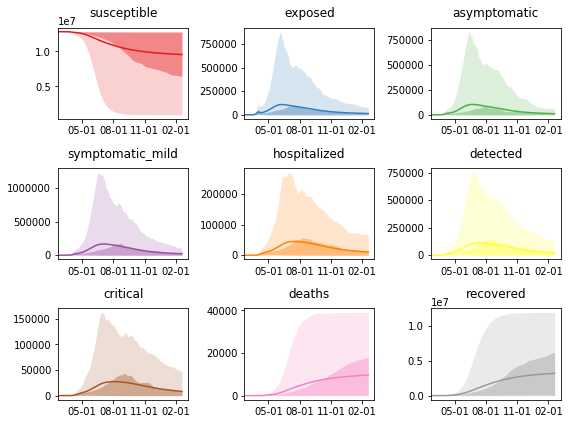

In [93]:
master_channel_list = ['susceptible', 'exposed', 'asymptomatic', 'symptomatic_mild',
                           'hospitalized', 'detected', 'critical', 'deaths', 'recovered']
first_day = date(2020, 2, 20)
sampleplot(df_final, allchannels=master_channel_list, first_day=first_day, plot_fname='main_channels.png')